## 캔들 패턴에 따른 투자
* 캔들 패턴을 바탕으로 매수와 매도 세력중 어느 세력이 강한지 판단하여 투자
* 상승장악형, 하락장악형, 적삼병, 흑삼병, 샛별형 다섯가지 캔들 패턴 구현

In [4]:
import os
import pandas as pd
from tqdm import tqdm

sp_data_dict = dict()
for file_name in tqdm(os.listdir("data/주가데이터")):
    sp_data = pd.read_csv("data/주가데이터/" + file_name, parse_dates = ['Date'])
    stock_name = file_name.replace('.csv', '')
    sp_data_dict[stock_name] = sp_data

100%|██████████| 2170/2170 [00:18<00:00, 116.36it/s]


In [5]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
sns.set()
%matplotlib inline
rcParams['font.family'] = 'Malgun Gothic'
rcParams['axes.unicode_minus'] = False

In [6]:
import warnings
warnings.filterwarnings("ignore")

### 상승장악형
* 음봉 다음에 음봉을 완전히 감싸는 양봉이 나오는 패턴
* 대표적인 매수 신호 패턴
* 전일에 음봉 생성 : 전일 시가 > 전일 종가
* 당일에 양봉 생성 : 당일 시가 < 당일 종가
* 전일 음봉이 당일 양봉에 포함 : 전일 저가 > 당일 시가 & 전일 고가 < 당일 종가
![상승장악형](images/상승장악형.jpg)

In [7]:
# 현대차를 예시로

sample_data = sp_data_dict["현대차"]

In [9]:
import numpy as np
from tqdm import tqdm

cond_1 = (sample_data['Open'] > sample_data['Close']).values[:-1]
cond_2 = (sample_data['Open'] < sample_data['Close']).values[1:]
cond_3 = (sample_data['Low'].values[:-1] > sample_data['Open'].values[1:])
cond_4 = (sample_data['High'].values[:-1] < sample_data['Close'].values[1:])

cond = cond_1 & cond_2 & cond_3 & cond_4
cond = np.insert(cond, 0, False)
sample_data["상승장악형"] = cond

In [10]:
for stock_name in tqdm(sp_data_dict.keys()):
    sp_data = sp_data_dict[stock_name]
    cond_1 = (sp_data['Open'] > sp_data['Close']).values[:-1]
    cond_2 = (sp_data['Open'] < sp_data['Close']).values[1:]
    cond_3 = (sp_data['Low'].values[:-1] > sp_data['Open'].values[1:])
    cond_4 = (sp_data['High'].values[:-1] < sp_data['Close'].values[1:])

    cond = cond_1 & cond_2 & cond_3 & cond_4
    cond = np.insert(cond, 0, False)
    sp_data["상승장악형"] = cond

100%|██████████| 2170/2170 [00:01<00:00, 1759.57it/s]


In [11]:
# 기대수익계산
# 상승장악형 패턴이 발생하고 n 영업일 이후의 수익률과 발생하지 않았을 때의 n 영업일 이후의 수익률 비교

def calc_ror_after_patt(sp_data, patt_col, n):
    patt_idx_list = sp_data.loc[sp_data[patt_col]].index
    no_patt_idx_list = sp_data.index.difference(patt_idx_list)
    max_idx = max(sp_data.index)

    patt_bidx_list = patt_idx_list[patt_idx_list + n < max_idx] + 1
    patt_sidx_list = patt_bidx_list + n
    no_patt_bidx_list = no_patt_idx_list[no_patt_idx_list + n < max_idx] + 1
    no_patt_sidx_list = no_patt_bidx_list + n

    # 패턴 발생 후 수익률 계산
    patt_bp_list = sp_data.loc[patt_bidx_list, 'Close'].values
    patt_sp_list = sp_data.loc[patt_sidx_list, 'Close'].values
    patt_ror_list = (patt_sp_list - patt_bp_list) / patt_bp_list * 100

    # 패턴 미 발생 후 수익률 계산
    no_patt_bp_list = sp_data.loc[no_patt_bidx_list, 'Close'].values
    no_patt_sp_list = sp_data.loc[no_patt_sidx_list, 'Close'].values
    no_patt_ror_list = (no_patt_sp_list - no_patt_bp_list) / no_patt_bp_list * 100

    return patt_ror_list.tolist(), no_patt_ror_list.tolist()

In [12]:
result_dict = dict()

# 5, 20, 60, 120일 이후의 수익률
for n in tqdm([5, 20, 60, 120]):
    total_patt_ror_list = []
    total_no_patt_ror_list = []
    for stock_name in sp_data_dict.keys():
        sp_data = sp_data_dict[stock_name]
        patt_ror_list, no_patt_ror_list = calc_ror_after_patt(sp_data, "상승장악형", n)
        total_patt_ror_list += patt_ror_list
        total_no_patt_ror_list += no_patt_ror_list
    result_dict[n] = total_patt_ror_list, total_no_patt_ror_list

100%|██████████| 4/4 [00:20<00:00,  5.10s/it]


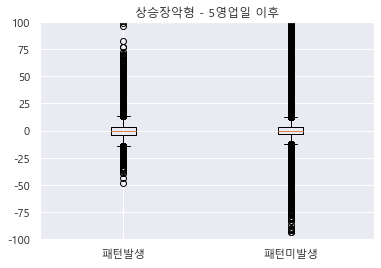

In [13]:
# 5 영업일 보유 시 수익 비교

plt.title("상승장악형 - 5영업일 이후")
plt.boxplot(result_dict[5])
plt.xticks([1, 2], ["패턴발생", "패턴미발생"])
plt.ylim(-100, 100)
plt.show()

# 패턴이 발생한 경우 아랫쪽 꼬리가 짧긴 하지만, 유의미하진 않음
# 다른 일수도 마찬가지

### 하락장악형
* 양봉 다음에 양봉을 완전히 감싸는 음봉이 나오는 패턴
* 대표적인 매도 신호 패턴
* 전일에 양봉 생성 : 전일 시가 < 전일 종가
* 당일에 음봉 생성 : 당일 시가 > 당일 종가
* 전일 양봉이 당일 음봉에 포함 : 전일 고가 < 당일 시가 & 전일 저가 > 당일 종가
![하락장악형](images/하락장악형.jpg)

In [15]:
for stock_name in sp_data_dict.keys():
    sp_data = sp_data_dict[stock_name]
    cond_1 = (sp_data['Open'] < sp_data['Close']).values[:-1]
    cond_2 = (sp_data['Open'] > sp_data['Close']).values[1:]
    cond_3 = (sp_data['High'].values[:-1] < sp_data['Open'].values[1:])
    cond_4 = (sp_data['Low'].values[:-1] > sp_data['Close'].values[1:])

    cond = cond_1 & cond_2 & cond_3 & cond_4
    cond = np.insert(cond, 0, False)
    sp_data["하락장악형"] = cond

In [16]:
result_dict = dict()

for n in [5, 20, 60, 120]:
    total_patt_ror_list = []
    total_no_patt_ror_list = []
    for stock_name in sp_data_dict.keys():
        sp_data = sp_data_dict[stock_name]
        patt_ror_list, no_patt_ror_list = calc_ror_after_patt(sp_data, "하락장악형", n)
        total_patt_ror_list += patt_ror_list
        total_no_patt_ror_list += no_patt_ror_list
    result_dict[n] = total_patt_ror_list, total_no_patt_ror_list

In [18]:
total_patt_ror_list, total_no_patt_ror_list = result_dict[5]
result = pd.concat([pd.Series(total_patt_ror_list).describe(),
                   pd.Series(total_no_patt_ror_list).describe()],
                   axis = 1)

result.columns = ['패턴발생', '패턴미발생']
print(result.round(2))

# 예상과 반대로 패턴이 발생했을 때의 수익률이 더 높음
# 나머지 일자에서도 마찬가지로 수익률이 마이너스가 아니며, 바로 매도하지 않고 가지고 있으면 어느정도 수익률이 나오는것을 알 수 있음

           패턴발생       패턴미발생
count  20086.00  4743382.00
mean       0.43        0.35
std        8.61        7.97
min      -62.50      -93.39
25%       -3.28       -3.21
50%        0.00        0.00
75%        3.39        3.05
max      151.49      900.11


### 적삼병
* 3일 연속으로 양봉이 나오며 종가가 오르는 현상으로 매수 신호 패턴
* 전전일 종가 < 전일 종가 < 당일 종가
* 전전일 시가 < 전전일 종가
* 전일 시가 < 전일 종가
* 당일 시가 < 당일 종가
![적삼병](images/적삼병.jpg)

In [21]:
for stock_name in sp_data_dict.keys():
    sp_data = sp_data_dict[stock_name]
    cur_price = sp_data["Close"].values[2:]
    pre_price = sp_data["Close"].values[1:-1]
    sec_pre_price = sp_data["Close"].values[:-2]

    cond_1 = (cur_price > pre_price) & (pre_price > sec_pre_price)
    cond_2 = (sp_data['Open'] < sp_data['Close']).values[:-2]
    cond_3 = (sp_data['Open'] < sp_data['Close']).values[1:-1]
    cond_4 = (sp_data['Open'] < sp_data['Close']).values[2:]

    cond = cond_1 & cond_2 & cond_3 & cond_4
    cond = np.insert(cond, [0, 0], False)
    sp_data["적삼병"] = cond

In [22]:
result_dict = dict()

for n in [5, 20, 60, 120]:
    total_patt_ror_list = []
    total_no_patt_ror_list = []
    for stock_name in sp_data_dict.keys():
        sp_data = sp_data_dict[stock_name]
        patt_ror_list, no_patt_ror_list = calc_ror_after_patt(sp_data, "적삼병", n)
        total_patt_ror_list += patt_ror_list
        total_no_patt_ror_list += no_patt_ror_list
    result_dict[n] = total_patt_ror_list, total_no_patt_ror_list

In [25]:
total_patt_ror_list, total_no_patt_ror_list = result_dict[5]
result = pd.concat([pd.Series(total_patt_ror_list).describe(),
                   pd.Series(total_no_patt_ror_list).describe()],
                   axis = 1)

result.columns = ['패턴발생', '패턴미발생']
print(result.round(2))

# 패턴이 발생했을때의 평균이 아주 살짝 높음. 또한 패턴이 발생했을때 중위수가 마이너스임. 패턴이 발생하더라도 손실이 나는 경우가 과반수인것
# 나머지 일자도 마찬가지의 결과가 나타났으며, 패턴이 발생했을때 평균이 조금 더 높지만 중위수가 마이너스로, 과반의 주가가 하락하였음

            패턴발생       패턴미발생
count  275344.00  4488124.00
mean        0.41        0.35
std         8.58        7.94
min       -62.50      -93.39
25%        -3.50       -3.19
50%        -0.31        0.00
75%         3.20        3.04
max       197.54      900.11


### 흑삼병
* 3일 연속으로 음봉이 나오며 종가가 떨어지는 현상으로 매도 신호 패턴
* 전전일 종가 > 전일 종가 > 당일 종가
* 전전일 시가 > 전전일 종가
* 전일 시가 > 전일 종가
* 당일 시가 > 당일 종가
![흑삼병](images/흑삼병.jpg)

In [27]:
for stock_name in sp_data_dict.keys():
    sp_data = sp_data_dict[stock_name]
    cur_price = sp_data["Close"].values[2:]
    pre_price = sp_data["Close"].values[1:-1]
    sec_pre_price = sp_data["Close"].values[:-2]

    cond_1 = (cur_price < pre_price) & (pre_price < sec_pre_price)
    cond_2 = (sp_data['Open'] > sp_data['Close']).values[:-2]
    cond_3 = (sp_data['Open'] > sp_data['Close']).values[1:-1]
    cond_4 = (sp_data['Open'] > sp_data['Close']).values[2:]

    cond = cond_1 & cond_2 & cond_3 & cond_4
    cond = np.insert(cond, [0, 0], False)
    sp_data["흑삼병"] = cond

In [28]:
result_dict = dict()

for n in [5, 20, 60, 120]:
    total_patt_ror_list = []
    total_no_patt_ror_list = []
    for stock_name in sp_data_dict.keys():
        sp_data = sp_data_dict[stock_name]
        patt_ror_list, no_patt_ror_list = calc_ror_after_patt(sp_data, "흑삼병", n)
        total_patt_ror_list += patt_ror_list
        total_no_patt_ror_list += no_patt_ror_list
    result_dict[n] = total_patt_ror_list, total_no_patt_ror_list

In [30]:
total_patt_ror_list, total_no_patt_ror_list = result_dict[5]
result = pd.concat([pd.Series(total_patt_ror_list).describe(),
                   pd.Series(total_no_patt_ror_list).describe()],
                   axis = 1)
result.columns = ['패턴발생', '패턴미발생']

print(result.round(2))

# 예상과 다르게 패턴이 발생한 경우가 약간 더 높은 평균 수익이 발생함
# 또한 패턴 발생 여부와 관계없이 과반이 손실을 보고, 반대로 큰 수익이 날 때도 있으므로 패턴이 발생하고 바로 매도하는것은 좋지 않음

            패턴발생       패턴미발생
count  395999.00  4367469.00
mean        0.37        0.35
std         7.89        7.98
min       -69.01      -93.39
25%        -3.33       -3.20
50%         0.00        0.00
75%         3.44        3.01
max       220.00      900.11


### 샛별형
* 전전날 긴 음봉이 나타나고 짧은 양봉, 그리고 긴 양봉이 순서대로 나타나는 상승 반전 패턴
* 전전일 종가 << 전전일 시가 (<< : 10% 이상 차이, < : 1% 미만 차이)
* 전일 종가 > 전일 시가
* 당일 종가 >> 당일 시가
![샛별형](images/샛별형.jpg)

In [31]:
for stock_name in sp_data_dict.keys():
    sp_data = sp_data_dict[stock_name]
    cond_1 = sp_data["Close"].values[:-2] <= sp_data["Open"].values[:-2] * 1.1
    cond_2 = sp_data["Close"].values[1:-1] > sp_data["Open"].values[1:-1]
    cond_3 = sp_data["Close"].values[1:-1] < sp_data["Open"].values[1:-1] * 1.01
    cond_4 = sp_data["Close"].values[2:] >= sp_data["Open"].values[2:] * 1.1

    cond = cond_1 & cond_2 & cond_3 & cond_4
    cond = np.insert(cond, [0, 0], False)
    sp_data["샛별형"] = cond

In [32]:
result_dict = dict()

for n in [5, 20, 60, 120]:
    total_patt_ror_list = []
    total_no_patt_ror_list = []
    for stock_name in sp_data_dict.keys():
        sp_data = sp_data_dict[stock_name]
        patt_ror_list, no_patt_ror_list = calc_ror_after_patt(sp_data, "샛별형", n)
        total_patt_ror_list += patt_ror_list
        total_no_patt_ror_list += no_patt_ror_list
    result_dict[n] = total_patt_ror_list, total_no_patt_ror_list

In [34]:
total_patt_ror_list, total_no_patt_ror_list = result_dict[5]
result = pd.concat([pd.Series(total_patt_ror_list).describe(),
                   pd.Series(total_no_patt_ror_list).describe()],
                   axis = 1)

result.columns = ['패턴발생', '패턴미발생']
print(result.round(2))

# 패턴이 발생했을 때 평균이 더 높으나, 중위수는 더 낮음. 이는 과반은 큰 손해를 보고, 나머지가 큰 이익을 본다는 의미

          패턴발생       패턴미발생
count  4726.00  4758742.00
mean      0.49        0.35
std      13.81        7.97
min     -61.58      -93.39
25%      -6.48       -3.21
50%      -0.96        0.00
75%       4.27        3.05
max     185.19      900.11
